In [110]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import seaborn as sns


In [111]:
df= pd.read_excel("merged_players.xlsx")


Étape 1 : Visualiser la distribution brute
python

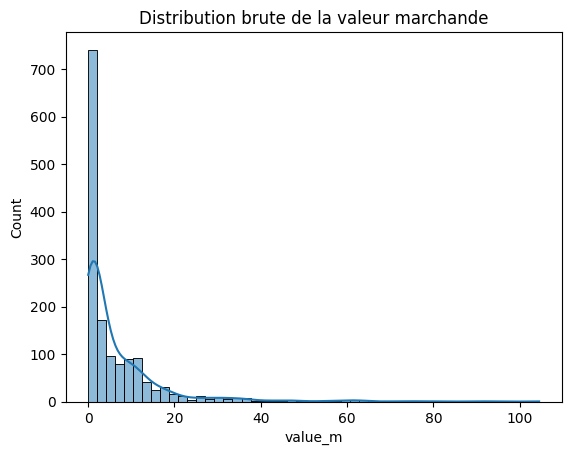

Skew initial : 3.722086279273958


In [112]:
sns.histplot(df['value_m'], kde=True, bins=50)
plt.title("Distribution brute de la valeur marchande")
plt.show()

print("Skew initial :", df['value_m'].skew())


Étape 2 : Tester plusieurs transformations

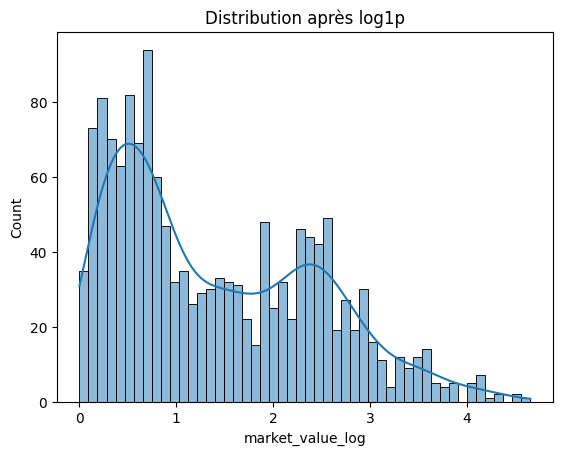

Skew après log1p : 0.6220904660546531


In [113]:
df['market_value_log'] = np.log1p(df['value_m'])

sns.histplot(df['market_value_log'], kde=True, bins=50)
plt.title("Distribution après log1p")
plt.show()

print("Skew après log1p :", df['market_value_log'].skew())


Transformation Box-Cox 

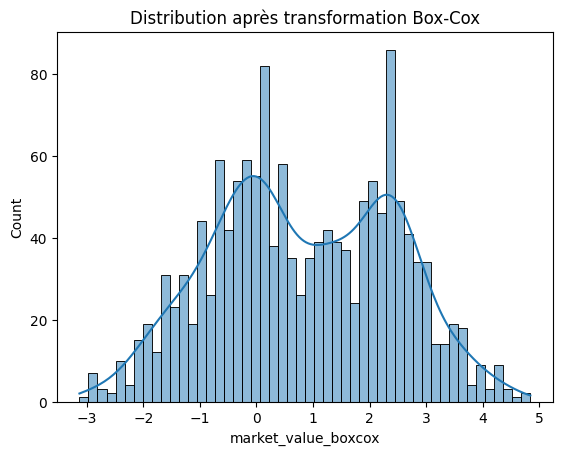

Lambda Box-Cox : 0.017572981682044308


In [114]:
from scipy.stats import boxcox

df = df[df['value_m'] > 0]  # Obligation pour Box-Cox
df['market_value_boxcox'], fitted_lambda = boxcox(df['value_m'])

sns.histplot(df['market_value_boxcox'], kde=True, bins=50)
plt.title("Distribution après transformation Box-Cox")
plt.show()

print("Lambda Box-Cox :", fitted_lambda)


Box-Cox est clairement meilleur ici car elle réduit la skewness presque à 0 (0.017), ce qui signifie une distribution beaucoup plus symétrique.

 log1p réduit bien la skewness mais reste encore modérément asymétrique (0.622).

On va choisir les meilleures variables explicatives pour la prédiction de la valeur marchande (market_value), en combinant analyse de corrélation, visualisations, et méthodes statistiques.

Étape 1 : Analyse de corrélation linéaire (Pearson)

release_clause_m            0.947686
wage_k                      0.862421
international_reputation    0.786774
overall_rating              0.743012
reactions                   0.660443
potential                   0.618290
composure                   0.477884
vision                      0.431127
shortpassing                0.350354
longpassing                 0.321292
Name: value_m, dtype: float64


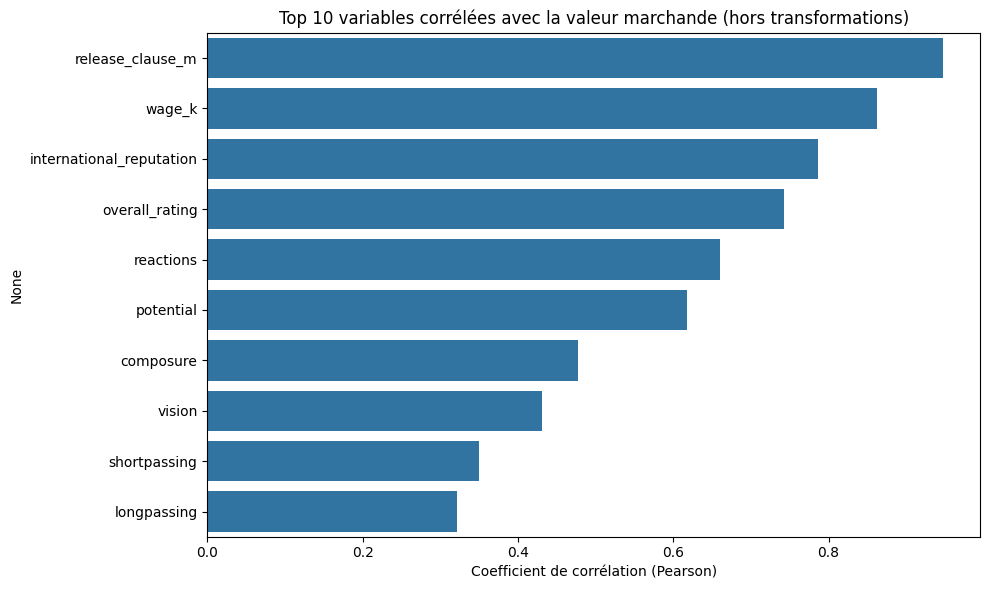

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conserver uniquement les colonnes numériques
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculer les corrélations
correlation_matrix = numeric_df.corr()

# Extraire les corrélations avec la valeur marchande
cor_target = correlation_matrix['value_m'].drop('value_m')

# Exclure les colonnes qui sont des transformations de la target
cor_target = cor_target.drop(labels=[col for col in cor_target.index if 'log' in col or 'boxcox' in col], errors='ignore')

# Trier les corrélations décroissantes
cor_target_sorted = cor_target.sort_values(ascending=False)

# Afficher les 10 plus corrélées
print(cor_target_sorted.head(10))

# Visualisation des corrélations
plt.figure(figsize=(10, 6))
sns.barplot(x=cor_target_sorted.head(10).values, y=cor_target_sorted.head(10).index)
plt.title("Top 10 variables corrélées avec la valeur marchande (hors transformations)")
plt.xlabel("Coefficient de corrélation (Pearson)")
plt.tight_layout()
plt.show()



Étape 2 : Analyse de corrélation non linéaire (Kendall ou Spearman)

overall_rating              0.975477
wage_k                      0.879527
reactions                   0.861217
release_clause_m            0.790265
potential                   0.777426
composure                   0.722088
ballcontrol                 0.665909
shortpassing                0.652158
international_reputation    0.623705
vision                      0.578690
Name: value_m, dtype: float64


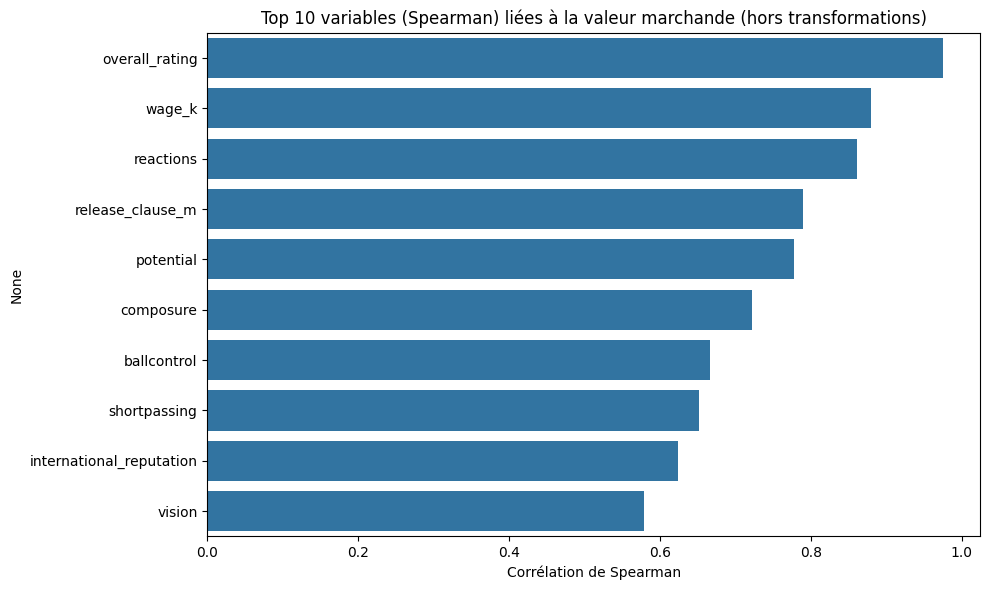

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# Corrélation de Spearman (relations monotones non linéaires)
spearman_corr = numeric_df.corr(method='spearman')['value_m'].drop('value_m')

# Exclure les colonnes dérivées de la target (log/boxcox)
spearman_corr = spearman_corr.drop(labels=[col for col in spearman_corr.index if 'log' in col or 'boxcox' in col], errors='ignore')

# Trier par ordre décroissant
spearman_corr_sorted = spearman_corr.sort_values(ascending=False)

# Afficher les 10 premières
print(spearman_corr_sorted.head(10))

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x=spearman_corr_sorted.head(10).values, y=spearman_corr_sorted.head(10).index)
plt.title("Top 10 variables (Spearman) liées à la valeur marchande (hors transformations)")
plt.xlabel("Corrélation de Spearman")
plt.tight_layout()
plt.show()



Étape 3 : Visualisations individuelles

Scatter plots (relations quantitatives)

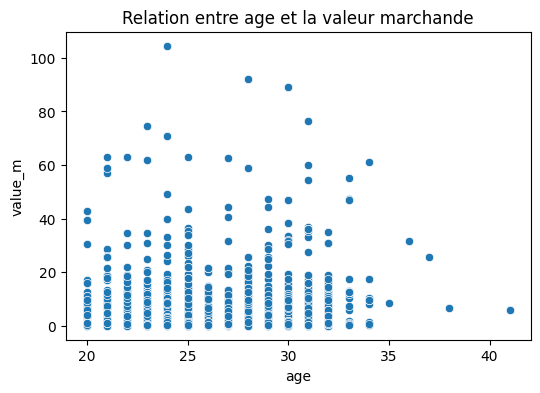

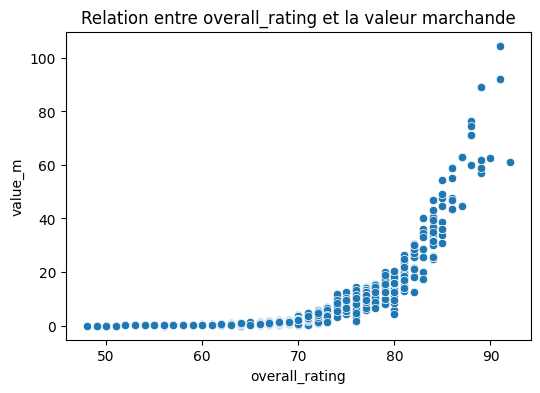

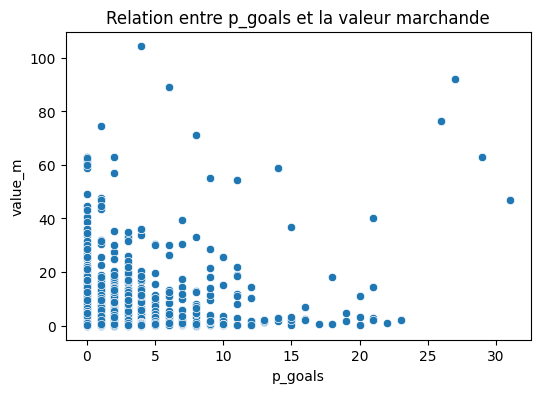

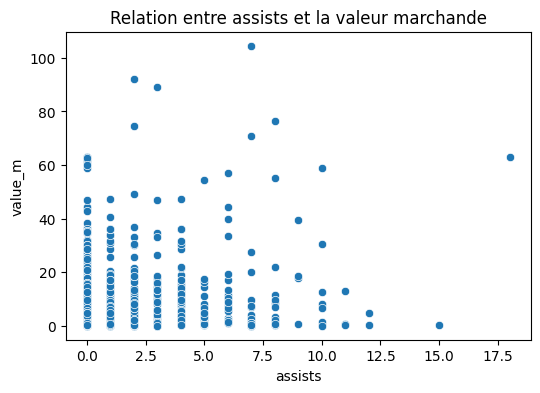

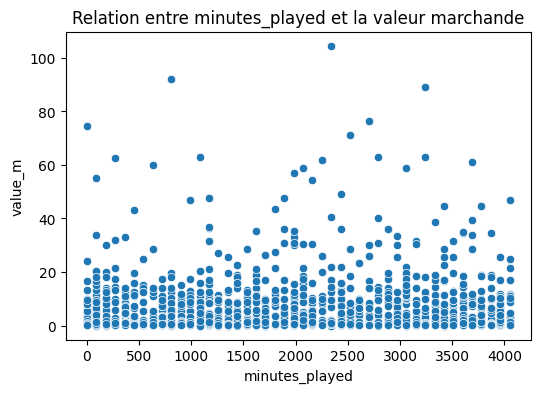

In [117]:
important_features = ['age', 'overall_rating', 'p_goals', 'assists', 'expected_goals', 'minutes_played']

for feature in important_features:
    if feature in df.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=df, x=feature, y='value_m')
        plt.title(f"Relation entre {feature} et la valeur marchande")
        plt.show()


Boxplots pour les variables catégorielles

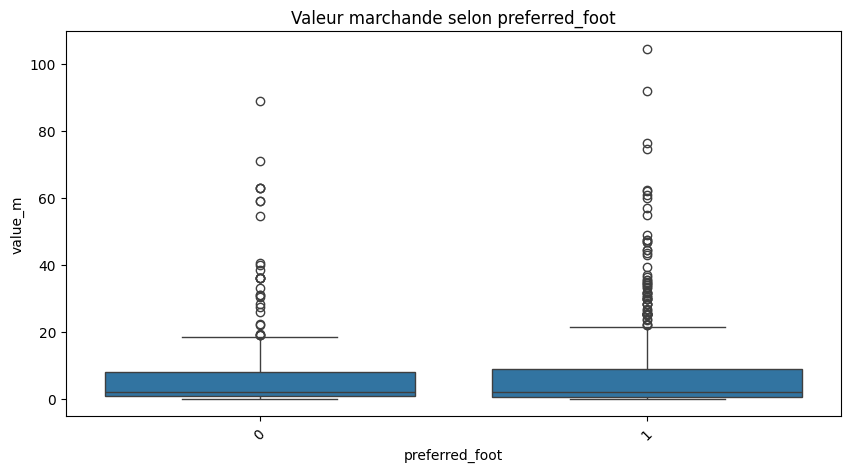

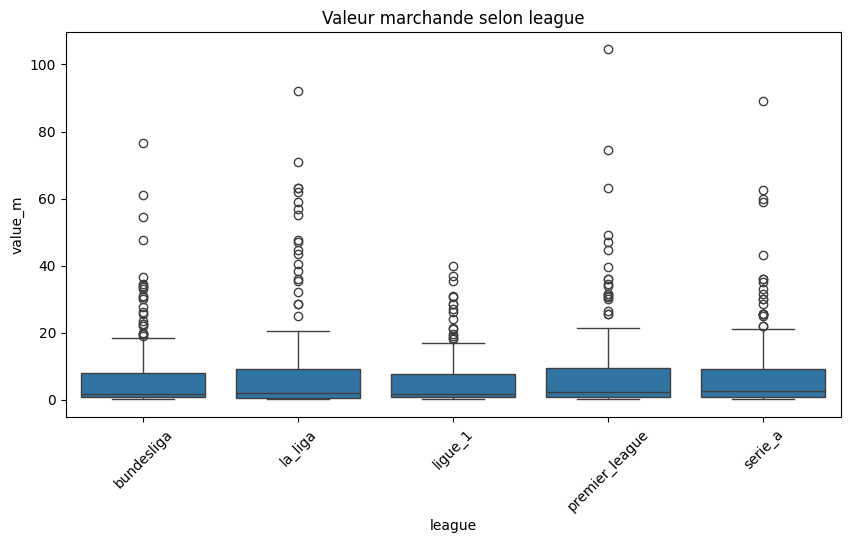

In [118]:
categorical = ['position', 'preferred_foot', 'league']

for col in categorical:
    if col in df.columns:
        plt.figure(figsize=(10,5))
        sns.boxplot(x=col, y='value_m', data=df)
        plt.title(f"Valeur marchande selon {col}")
        plt.xticks(rotation=45)
        plt.show()


Étape 4 : Sélection automatique avec SelectKBest

In [135]:
from sklearn.feature_selection import SelectKBest, f_regression

X = numeric_df.drop(columns=['value_m'])
y = numeric_df['value_m']

selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X, y)

selected_features = X.columns[selector.get_support()]
print("Top 10 features sélectionnées :", selected_features.tolist())


Top 10 features sélectionnées : ['wage_k', 'release_clause_m', 'overall_rating', 'composure', 'international_reputation', 'potential', 'reactions', 'vision', 'market_value_log', 'market_value_boxcox']


In [120]:
from sklearn.model_selection import train_test_split

# Définir les features et cibles
features = [
    # Profil du joueur
    "age", "young", "wage_k", "overall_rating", "potential", "international_reputation",

    # Performances
    "p_goals", "assists", "expected_goals_(xg)", "accurate_passes_%",
    "minutes_played", "p_matches_played", "t_matches_played",
    "wins", "draws", "loses", "goals_for", "goals_against",
    "difference", "points",

    # Attributs techniques
    "composure", "vision", "shortpassing", "ballcontrol",
    "finishing", "shotpower", "dribbling", "reactions",

    # Position encodée
    "striker", "midfielder", "defender", "goalkeeper"
]

target_transformed = 'market_value_boxcox'

X = df[features]
y_trans = df[target_transformed].values.reshape(-1, 1)
y_orig = df['value_m'].values.reshape(-1, 1)

# Split sur X et y_trans (transformation Box-Cox)
X_train, X_test, y_train_trans, y_test_trans = train_test_split(
    X, y_trans, test_size=0.2, random_state=42
)

# Faire le même split sur y_orig (cible non transformée)
_, _, _, y_test_orig = train_test_split(
    X, y_orig, test_size=0.2, random_state=42
)


Étape 1 – Régression Linéaire

In [121]:
def inverse_boxcox(y_boxcox, lmbda):
    if lmbda == 0:
        return np.exp(y_boxcox)
    else:
        return np.power((y_boxcox * lmbda) + 1, 1 / lmbda)

In [122]:
# === 6. Random Forest ===
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_trans.ravel())
y_pred_rf_trans = rf_model.predict(X_test)
y_pred_rf = inverse_boxcox(y_pred_rf_trans.reshape(-1, 1), fitted_lambda)

In [139]:
# === 7. XGBoost ===
from xgboost import XGBRegressor


xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train_trans.ravel())
y_pred_xgb_trans = xgb_model.predict(X_test)
y_pred_xgb = inverse_boxcox(y_pred_xgb_trans.reshape(-1, 1), fitted_lambda)

Évaluation des performances

In [142]:
models = ['Random Forest', 'XGBoost']
mae_scores = [
    mean_absolute_error(y_test_orig, y_pred_rf),
    mean_absolute_error(y_test_orig, y_pred_xgb)
]
rmse_scores = [
    np.sqrt(mean_squared_error(y_test_orig, y_pred_rf)),
    np.sqrt(mean_squared_error(y_test_orig, y_pred_xgb))
]
r2_scores = [
    r2_score(y_test_orig, y_pred_rf),
    r2_score(y_test_orig, y_pred_xgb)
]

# Affichage
for model, mae, rmse, r2 in zip(models, mae_scores, rmse_scores, r2_scores):
    print(f"📌 {model}")
    print(f"MAE : {mae:.3f} M€")
    print(f"RMSE : {rmse:.3f} M€")
    print(f"R² : {r2:.4f}")
    print("-" * 30)


📌 Random Forest
MAE : 0.552 M€
RMSE : 1.497 M€
R² : 0.9750
------------------------------
📌 XGBoost
MAE : 0.395 M€
RMSE : 0.900 M€
R² : 0.9910
------------------------------


Prédictions sur des joueurs connus

In [138]:
X_test_copy = X_test.copy()
X_test_copy["true_value"] = y_test_orig
X_test_copy["predicted_value"] = y_pred_xgb
X_test_copy["name"] = df.loc[X_test.index, "name"]

# Exemple de joueurs connus
exemples = ["kylian_mbappe"]
df_sample = X_test_copy[X_test_copy["name"].isin(exemples)]

# Sauvegarde et affichage
print(df_sample[["name", "true_value", "predicted_value"]])



              name  true_value  predicted_value
278  kylian_mbappe        47.0        42.879618


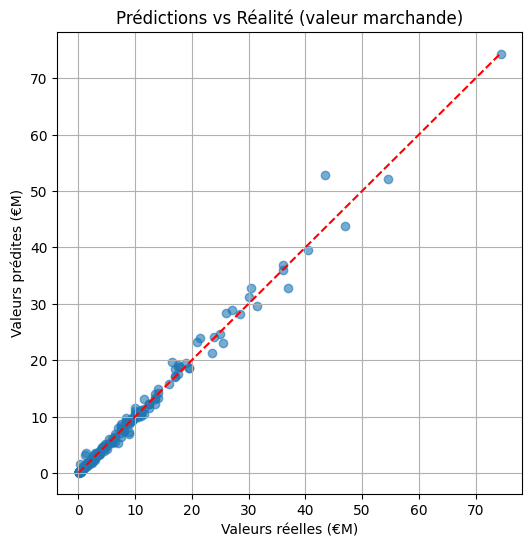

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_orig, y_pred_xgb, alpha=0.6)
plt.plot([min(y_test_orig), max(y_test_orig)],
         [min(y_test_orig), max(y_test_orig)],
         color='red', linestyle='--')
plt.xlabel("Valeurs réelles (€M)")
plt.ylabel("Valeurs prédites (€M)")
plt.title("Prédictions vs Réalité (valeur marchande)")
plt.grid(True)
plt.show()

In [155]:
from scipy.special import inv_boxcox

# Prédictions sur les données de test (transformed)
y_pred_trans = xgb_model.predict(X_test)

# Inverser la transformation Box-Cox
y_pred_real = inv_boxcox(y_pred_trans, fitted_lambda)
y_test_real = inv_boxcox(y_test_trans.flatten(), fitted_lambda)

# Supprimer la première ligne (index 0)
y_test_real = y_test_real[1:]
y_pred_real = y_pred_real[1:]

# Créer DataFrame avec index démarrant à 1
comparison_df = pd.DataFrame({
    'Valeur réelle (€M)': y_test_real,
    'Valeur prédite (€M)': y_pred_real
}, index=range(1, len(y_pred_real) + 1))

# Affichage
print(comparison_df.head(10))


    Valeur réelle (€M)  Valeur prédite (€M)
1                 1.30             1.406177
2                 0.55             0.607651
3                17.00            17.034665
4                 3.20             3.378586
5                14.00            13.293898
6                 7.50             8.771967
7                 9.00             6.944076
8                 2.30             2.332739
9                11.00            10.389695
10                9.50             9.278489
